### Lagrangian filtering vs interpolated filtered signal

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp
import pyinterp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7765358.datarmor0/parcels-502090/libparcels_random_fd38d48e-8358-47b7-a664-ec591da6ab05.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

In [3]:
isel = dict(face=7)
sel = dict(i=slice(2700,2900), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
sel_interp = dict(i=slice(2500,2900), j=slice(2300,3400))
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [5]:
def binned_spectra_site(bbox,df,group,dl):
    df_sub = df[(df.lat<=bbox[3])&(df.lat>bbox[2])&(df.lon<bbox[1])&(df.lon>bbox[0])
                                               ].persist()

    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    if np.isin('h',df_sub.columns):
        df_sub = df_sub.drop(columns=['h'])
    uv_sub = df_sub.groupby(group).mean().compute() #['lat_cut']
    df_count = df_sub.groupby(group).count().compute()
    df_count = df_count.set_index(df_count.index.map(lambda v: v.mid))['lon'].to_xarray()#['lon']
    _ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
                                  ).drop(columns=['time','lon','lat']
                                        ).reset_index(),id_vars=group,var_name='frequency')#['lat_cut']

    _ds['frequency'] = _ds['frequency'].astype('float64')
    cols = {V : V.split('_')[0]+'_bins' for V in group}
    cols.update({'value':'uv'})
    #print( cols)
    index = [V.split('_')[0]+'_bins' for V in group]+['frequency']
    #print(index)
    ds_sub = _ds.rename(columns=cols
                   ).to_xarray().set_index(index=index).unstack()
    return ds_sub,df_count
def binned_Espectra_site(bbox,ds,group,dl):
    ds['lat'] = 0*ds_E.face+ds.YC
    ds['lon'] = 0*ds_E.face+ds.XC
    ds['lat4'] = 0*ds_E.SSUV+ds.YC
    ds = ds.persist()
    ds_sub = ds.where((ds.lat<=bbox[3])&(ds.lat>=bbox[2])&(ds.lon<=bbox[1])&(ds.lon>=bbox[0]),drop=True).persist()
    lat = np.arange(bbox[-2], bbox[-1], dl)
    lon = np.arange(bbox[0], bbox[1], dl)
    if group==['lat_cut']:
        N = histogram(ds_sub.lat, bins=[lat], 
                  dim=['i', 'j', 'face']
                 ).persist()
        E = histogram(ds_sub.lat4.rename('lat'), bins=[lat], 
                  weights=ds_sub.SSUV, 
                  dim=['i', 'j', 'face']
                 )
    if group==['lon_cut','lat_cut']:
        N = histogram(ds_sub.lon,ds_sub.lat, bins=[lon,lat], 
                  dim=['i', 'j', 'face']
                 ).persist()
        E = histogram(ds_sub.lon,ds_sub.lat, bins=[lon,lat], 
                  weights=ds_sub.SSUV, 
                  dim=['i', 'j', 'face']
                 )
    cols = {V.split('_')[0]+'_bin' : V.split('_')[0]+'_bins' for V in group}
    cols.update({'freq_time': 'frequency'})
    E = (E/N).rename('E_SSUV').persist()
    E = E.rename(cols)
    return E

In [21]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
#out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_california")
#llc_zarr = os.path.join(out_dir, "llc.zarr")

#parcels_index= 'time_mean'
#parcels_name = "llc_parcels_"+parcels_index
#parcels_path = os.path.join(out_dir, parcels_name)



In [22]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_uv_T60_mean0').persist()#persist()
#df_Lspectra_mean1 = p.load_diagnostic('spectra_uv_T60_mean1').persist()#persist()
#df_Lspectra_mean2 = p.load_diagnostic('spectra_uv_T60_mean2').persist()#compute()

In [24]:
df_Lspectra_mean0.index

Dask Index Structure:
npartitions=87
    int64
      ...
    ...  
      ...
      ...
Name: trajectory, dtype: int64
Dask Name: read-parquet, 174 tasks

In [7]:
#sub = 2
import os
ds_E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_SSUV_T60.zarr'))
ds_E = ds_E.isel(**isel).sel(**sel)
ds_E = ds_E.where(ds_E.Depth>500, drop=False)
print(ds_E)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, i: 51, j: 51)
Coordinates:
    Depth      (j, i) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    face       int64 7
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 2700 2704 2708 2712 2716 ... 2884 2888 2892 2896 2900
  * j          (j) int64 2900 2904 2908 2912 2916 ... 3084 3088 3092 3096 3100
    mask       (j, i) bool dask.array<chunksize=(51, 51), meta=np.ndarray>
Data variables:
    SSUV       (j, i, freq_time) float64 dask.array<chunksize=(43, 51, 1440), meta=np.ndarray>


In [8]:
mean_spectra = ds_E.SSUV.mean(['i','j']).compute()

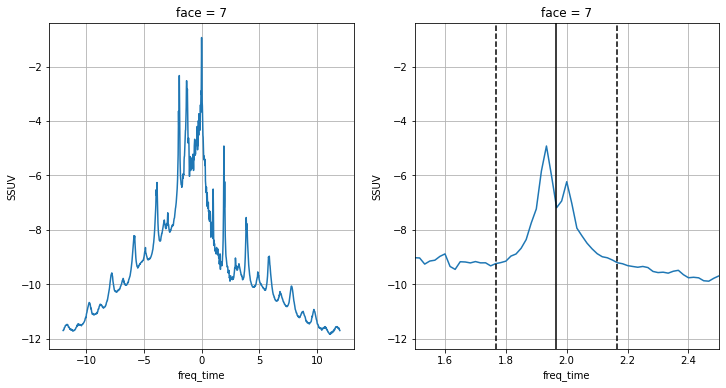

In [20]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
np.log(mean_spectra).plot(ax=axs[0]);axs[0].grid()
np.log(mean_spectra).plot(ax=axs[1],xlim=(1.5,2.5));axs[1].grid()
axs[1].axvline(omega-dband,c='k',linestyle='--');axs[1].axvline(omega+dband,c='k',linestyle='--')
axs[1].axvline(omega,c='k',linestyle='-')

In [25]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr'),xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr'),
               xr.open_zarr(ut.work_data_dir+'rechunked/Eta.zarr')
              ])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [26]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [27]:
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10
dsp

<xarray.Dataset>
Dimensions:  (i: 101, j: 101, time: 8784)
Coordinates:
  * i        (i) int64 2700 2702 2704 2706 2708 ... 2892 2894 2896 2898 2900
  * j        (j) int64 2900 2902 2904 2906 2908 ... 3092 3094 3096 3098 3100
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>

In [28]:
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()



In [9]:
ds_interp = ds.isel(**isel).sel(**sel_interp)
ds_interp = ds_interp.chunk({"time": -1}).persist() #,"i":10,"j":10
ds_interp

<xarray.Dataset>
Dimensions:  (i: 201, j: 551, time: 8784)
Coordinates:
  * i        (i) int64 2500 2502 2504 2506 2508 ... 2892 2894 2896 2898 2900
  * j        (j) int64 2300 2302 2304 2306 2308 ... 3392 3394 3396 3398 3400
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(551, 201), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(551, 201), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(551, 201), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(551, 201), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(551, 201), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(551, 201), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 2, 46), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 2, 46), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(8784, 2, 46), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(551, 201), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(551, 201), meta=np.ndarray>

In [10]:
ds_interp['zonal_velocity'] = ds_interp['SSU']*ds_interp.CS - ds_interp['SSV']*ds_interp.SN
ds_interp['meridional_velocity'] =  ds_interp['SSU']*ds_interp.SN + ds_interp['SSV']*ds_interp.CS
ds_interp = ds_interp.assign_coords({'lon':ds_interp.lon,'lat':ds_interp.lat})
ds_interp = ds_interp.drop(['SSU','SSV']).persist()



In [29]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [30]:
def wrap_filter(_ds,om,Tw,dband,V,dt=dt):
    h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*omega*2*np.pi*time)
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True).persist()
        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real']=ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag']=ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])
    return ds_hat,h
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'T_window':T_window,'bandwidth':[b*2 for b in bandwidths]})

In [32]:
V = ['zonal_velocity','meridional_velocity'
    ]
Tw = 30
dband=0.2 #half bandwidth

ds_hat,h = wrap_filter(dsp,omega,Tw,dband,V)

In [14]:
ds_hat_tot,h = wrap_filter(ds_interp,omega,Tw,dband,V)

In [15]:
ds_hat_tot = xr.merge([ds_hat_tot,ds_interp])

In [33]:
ds_hat = xr.merge([ds_hat,dsp])

In [34]:
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


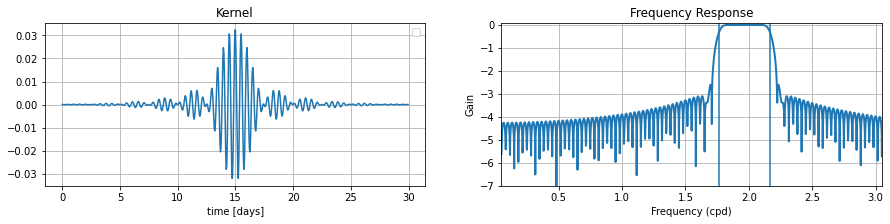

In [35]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
    #t = np.arange(0, h.size)*dt
t = np.arange(0, h.size)*dt
ax.plot(t, h);
ax.grid();
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()
ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband)#, color='k')
ax.axvline(omega+dband)#, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)
    #H.plot.line(hue='T_window')

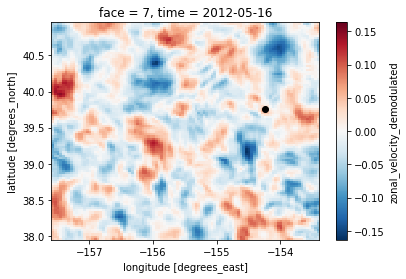

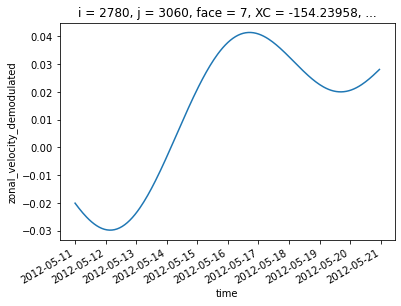

In [19]:
ds_hat.isel(time=int(366//2*24)).zonal_velocity_demodulated.real.plot(x='XC',y='YC')
plt.scatter(ds_hat.isel(i=40,j=80).XC,ds_hat.isel(i=40,j=80).YC,c='k')
plt.figure()
ds_hat.isel(i=40,j=80,time=slice(int(366//2*24-5*24),int(366//2*24+5*24))).zonal_velocity_demodulated.real.plot()

### Drifters

In [36]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time_mean'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15    39000000  57.835732 -178.867081  0.0             0.0   
2011-11-15    39000001  58.429878 -178.871994  0.0             0.0   
2011-11-15    39000002  59.018066 -178.879623  0.0             0.0   
2011-11-15    39000003  59.600288 -178.890015  0.0             0.0   
2011-11-15    39000004  60.176525 -178.903275  0.0             0.0   

            meridional_velocity  sea_level  temperature  salinity  Eta_interp  \
time                                                                            
2011-11-15                  0.0        0.0          0.0       0.0    0.060997   
2011-11-15                  0.0        0.0          0.0       0.0    0.075155   
2011-11-15                  0.0        0.0          0.0       0.0    0.169278   
2011-11-15                  0.0        0.0          0.0       0.0    0.242839   
2011-11-15                  0.0        0.0          0.0       0.0    0.222071   

            SSU_interp  SST_interp  SSV_interp  SSS_interp  
time                                                        
2011-11-15   -0.002461    4.279537   -0.006017   33.194778  
2011-11-15   -0.091730    4.326020    0.050204   33.139637  
2011-11-15   -0.203138    4.161501    0.209887   32.961617  
2011-11-15   -0.075768    3.679666    0.064889   32.712219  
2011-11-15   -0.006189    3.151162    0.057710   32.573410

In [37]:
df = df.drop(columns=['temperature','salinity','Eta_interp','SSU_interp','SSV_interp','SST_interp','SSS_interp'])

In [38]:
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [39]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
#traj = _df.index.drop_duplicates(keep='first').compute()#["index"]

df_selected = df[df.trajectory.isin(traj)]

In [100]:
df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
                                                      ).drop(columns='trajectory').reset_index().set_index('time').persist()

<ipython-input-100-ce76bf29eb72>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_selected = df_selected.groupby('trajectory').apply(remove_duplicates


In [41]:
Lspectra = df_Lspectra_mean0.loc[traj].persist()#[df_Lspectra_mean0.trajectory.isin(traj)]

In [43]:
df_Lspectra_mean0 = df_Lspectra_mean0[ (df_Lspectra_mean0.lon>=bbox[0])
                                        &(df_Lspectra_mean0.lon<=bbox[1])
                                        &(df_Lspectra_mean0.lat>=bbox[2])
                                        &(df_Lspectra_mean0.lat<=bbox[3])
                                     ].persist()

In [83]:
mean_Lspectra = df_Lspectra_mean0.drop(columns=['time','lon','lat']).mean().compute()

#_ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
#                                  ).drop(columns=['time','lon','lat']
#                                        ).reset_index(),id_vars=group,var_name='frequency')

In [84]:
#mean_Lspectra['index2'] = mean_Lspectra.index.astype('float64')
mean_Lspectra = mean_Lspectra.reset_index().sort_values('index').set_index('index')
mean_Lspectra['index2'] = mean_Lspectra.index.astype('float64')


In [87]:
mean_Lspectra = mean_Lspectra.reset_index().drop(columns='index').sort_values('index2').set_index('index2')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


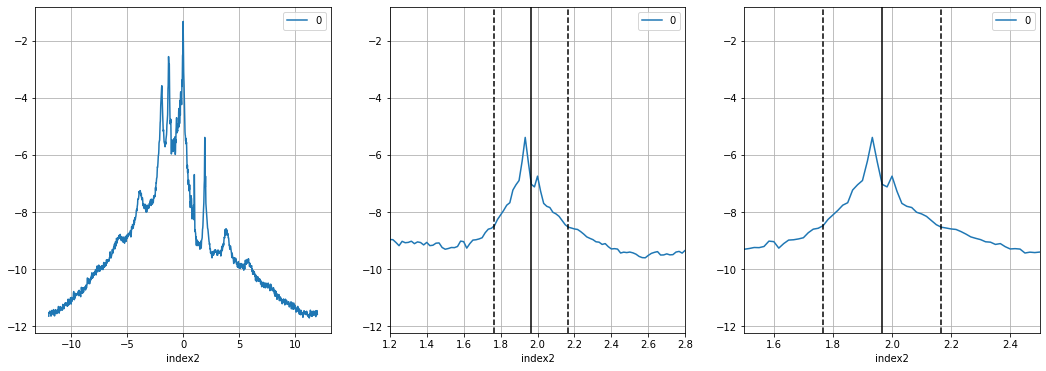

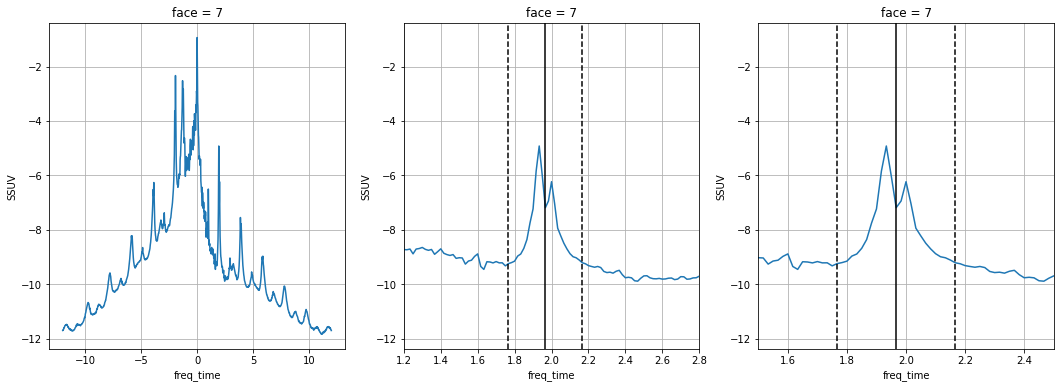

In [96]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
np.log(mean_Lspectra).plot(ax=axs[0]);axs[0].grid()
np.log(mean_Lspectra).plot(ax=axs[1],xlim=(1.2,2.8));axs[1].grid()
np.log(mean_Lspectra).plot(ax=axs[2],xlim=(1.5,2.5));axs[2].grid()
for ax in axs[1:]:
    ax.axvline(omega-dband,c='k',linestyle='--');ax.axvline(omega+dband,c='k',linestyle='--')
    ax.axvline(omega,c='k',linestyle='-')

fig, axs = plt.subplots(1,3,figsize=(18,6))
np.log(mean_spectra).plot(ax=axs[0]);axs[0].grid()
np.log(mean_spectra).plot(ax=axs[1],xlim=(1.2,2.8));axs[1].grid()
np.log(mean_spectra).plot(ax=axs[2],xlim=(1.5,2.5));axs[2].grid()
for ax in axs[1:]:
    ax.axvline(omega-dband,c='k',linestyle='--');ax.axvline(omega+dband,c='k',linestyle='--')
    ax.axvline(omega,c='k',linestyle='-')

In [97]:
def remove_duplicates(df):
    df = df.reset_index().drop_duplicates('time').sort_values('time').set_index('time')
    dt_df = df.index[1:]-df.index[:-1]
    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [98]:
def filt_L(v, h,columns, hilbert=False):
    vc = v.copy()
    #vc = vc.groupby(vc.index).first()#.drop_duplicates
    #vc = vc.groupby(level=df1.index.names).last()
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h=h,hilbert=hilbert)
    time = np.arange(0,vc.index.size*dt,dt)#.compute()
    exp = np.exp(-1j*omega*2*np.pi*time)
    for V in columns:
        vc[V+'_demodulated'] = vc[V+'_hat']*exp
    return vc

In [99]:
Tw = Tw
dband= dband
omega = omega #(omega_M2+omega_S2)/2
hL = h#sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)


In [29]:
_f = df_selected[df_selected.trajectory==38000248].compute()
print('Number of data points,  with duplicates : ', _f.index.size)
print('Number of data points, no duplicates : ',np.unique(_f.index).size)

Number of data points,  with duplicates :  9360
Number of data points, no duplicates :  8642


In [30]:
_f_bis = _f.reset_index().drop_duplicates('time').sort_values('time').set_index('time')

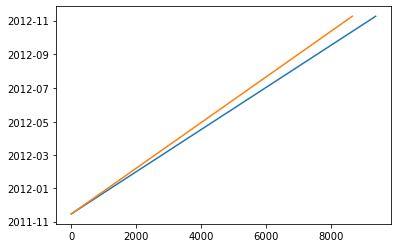

In [33]:
plt.plot(_f.index)
plt.plot(_f_bis.index)

In [40]:
dt_f = _f.index[1:]-_f.index[:-1]
dt_f_bis = _f_bis.index[1:]-_f_bis.index[:-1]

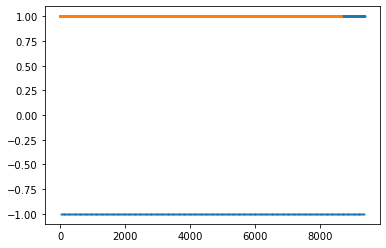

In [50]:
plt.scatter(np.arange(0,_f.index.size-1),dt_f*1e-9/3600,s=1)
plt.scatter(np.arange(0,_f_bis.index.size-1),dt_f_bis*1e-9/3600,s=1)

In [61]:
np.insert(dt_f_bis!=np.timedelta64(1,'h'),0,True)

array([ True, False, False, ..., False, False, False])

In [62]:
_f_bis['flag'] = np.insert(dt_f_bis!=np.timedelta64(1,'h'),0,False)

In [66]:
test = df_selected[df_selected.trajectory==37001825].compute()

In [70]:
test[test.flag==True].shape

(0, 8)

In [106]:
#df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
#                                                      ).drop(columns='trajectory').reset_index().set_index('time').persist()
df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],hilbert=True).persist()
#df_filtered = df_filtered.repartition(npartitions=10).persist()

df_filtered = df_filtered.drop(columns='trajectory').reset_index().sort_values('time').set_index('time').persist()

<ipython-input-106-59c271114a6e>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],hilbert=True).persist()


In [73]:
_f = df_filtered[df_filtered.trajectory==38000248].compute()
print('Number of duplicates : ',_f.index.size-np.unique(_f.index).size)
print('Number of gap in data : ',_f[_f.flag==True].shape[0])

Number of duplicates :  0
Number of gap in data :  0


In [74]:
print(df_filtered.index.values.compute()[-1],ds_hat.time.values[-1])

2012-11-09T01:00:00.000000000 2012-11-14T23:00:00.000000000


In [107]:
dt = 1/24
t_mid = int(360/dt//2)
dtime = int(10/dt)

In [109]:
dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
_df1 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==37000174].compute()
_df2 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000248].compute()
_df3 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38001401].compute()
_df4 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000024].compute()
_df5 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000172].compute()
_df6 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000097].compute()

In [111]:
for _f in [_df1,_df2,_df3,_df4,_df5,_df6]:
    print('Drifter number ',_f.trajectory.values[0])
    print('Number of duplicates : ',_f.index.size-np.unique(_f.index).size)
    print('Number of gap in data : ',_f[_f.dt_flag==True].shape[0])

Drifter number  37000174
Number of duplicates :  0
Number of gap in data :  0
Drifter number  38000248
Number of duplicates :  0
Number of gap in data :  0
Drifter number  38001401
Number of duplicates :  0
Number of gap in data :  0
Drifter number  38000024
Number of duplicates :  0
Number of gap in data :  0
Drifter number  38000172
Number of duplicates :  0
Number of gap in data :  0
Drifter number  38000097
Number of duplicates :  0
Number of gap in data :  0


In [112]:
print('Gaps in data : ', df_filtered[df_filtered.dt_flag==True].shape[0].compute())

Gaps in data :  0


In [113]:
time = _df2.index

In [114]:
df_mid = _df1.loc[time[time.size//2]]
#df_mid = dfi.loc[time[time.size//2]]
df_mid_2 = _df2.loc[time[time.size//2]]

In [115]:
eps = 0.01
ds_mid = dsi.where((dsi.lon<=df_mid.lon+eps)&(dsi.lon>=df_mid.lon-eps)&
                                                   (dsi.lat<=df_mid.lat+eps)&(dsi.lat>=df_mid.lat-eps),drop=True)#.sel(time=time[time.size//2])


In [116]:
eps = 0.015
ds_mid_2 = dsi.where((dsi.lon<=df_mid_2.lon+eps)&(dsi.lon>=df_mid_2.lon-eps)&
                                                   (dsi.lat<=df_mid_2.lat+eps)&(dsi.lat>=df_mid_2.lat-eps),drop=True)#.sel(time=time[time.size//2])

In [117]:
ds_mid_2

<xarray.Dataset>
Dimensions:                               (i: 1, j: 1, time: 480)
Coordinates:
  * i                                     (i) int64 2790
  * j                                     (j) int64 3024
    face                                  int64 7
  * time                                  (time) datetime64[ns] 2012-05-03 .....
    XC                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    YC                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Depth                                 (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    CS                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SN                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rA                                    (j, i) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon                                   (j, i) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat                                   (j, i) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Data variables:
    zonal_velocity_hat                    (j, i, time) complex128 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    zonal_velocity_demodulated            (j, i, time) complex128 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    zonal_velocity_demodulated_real       (j, i, time) float64 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    zonal_velocity_demodulated_imag       (j, i, time) float64 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    meridional_velocity_hat               (j, i, time) complex128 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    meridional_velocity_demodulated       (j, i, time) complex128 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    meridional_velocity_demodulated_real  (j, i, time) float64 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    meridional_velocity_demodulated_imag  (j, i, time) float64 dask.array<chunksize=(1, 1, 480), meta=np.ndarray>
    Eta                                   (time, j, i) float32 dask.array<chunksize=(480, 1, 1), meta=np.ndarray>
    zonal_velocity                        (time, j, i) float32 dask.array<chunksize=(480, 1, 1), meta=np.ndarray>
    meridional_velocity                   (time, j, i) float32 dask.array<chunksize=(480, 1, 1), meta=np.ndarray>

In [118]:
def interp_sig(_df, dsi,v,time,part=None):
    idw_eta, neighbors = [],[]
    idw_eta_mid, neighbors_mid = [],[]
    
    for it in range(0,_df.index.values.size):
    #for t in time
        mesh = pyinterp.RTree()
        _dsi = dsi.isel(time=it)#
        if part=='real':
            var = np.real(_dsi[v].values)
        elif part=='imag':
            var = np.imag(_dsi[v].values)
        else:
            var = _dsi[v].values
        mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                                _dsi.YC.values.flatten())).T,
                         var.flatten(),
                        )

        idw_eta.append(mesh.inverse_distance_weighting(
                np.vstack((_df.lon[it], _df.lat[it])).T,
                within=True,
                radius=5e5,
                k=4,  
                num_threads=0)[0])
        neighbors.append(mesh.inverse_distance_weighting(
                np.vstack((_df.lon[it], _df.lat[it])).T,
                within=True,
                radius=5e5,
                k=4,  
                num_threads=0)[1])
        idw_eta_mid.append(mesh.inverse_distance_weighting(
                    np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                    within=True,
                    radius=5e5,
                    k=4,  
                    num_threads=0)[0])
        neighbors_mid.append(mesh.inverse_distance_weighting(
                    np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                    within=True,
                    radius=5e5,
                    k=4,  
                    num_threads=0)[1])
    interp = idw_eta[0]
    for i in idw_eta[1:]:
        interp = np.insert(i,-1,interp)
    interp_mid = idw_eta_mid[0]
    for i in idw_eta_mid[1:]:
        interp_mid = np.insert(i,-1,interp_mid)
    return interp, interp_mid

In [119]:
def gen_figs_flts_interp(_df,idw_eta,it,v,dt,savefig=False):
    name=v+'_%s'%it
    _s = dsi.isel(time=it)
    t = _s.time.values
    fig,axs= plt.subplots(2,2,figsize=(10,10))
#    fig = plt.figure(figsize=(10,10),constrained_layout=True)
#    gs = gridspec.GridSpec(2, 2, figure=fig)
#    ax = fig.add_subplot(gs[0, 0],sharey=True)
    ax= axs[0,0]
    _s[v+'_demodulated'].real.plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False,cmap='RdBu_r')
                                                  #,cbar_kwargs={'label':'Demodulated '+v+' : real part'})
    if it>= 3/dt:
        t0 = t-np.timedelta64(3,'D')
    else:
        t0= dsi.isel(time=0).time.values
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)   
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(ds_mid[v+'_demodulated'].lon.values,ds_mid[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : real part');#ax.set_aspect('equal');
    ax=axs[0,1]
    cs = dsi[v+'_demodulated'].imag.isel(time=it).plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False)
                                                 # ,cbar_kwargs={'label':'Demodulated velocity'})
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)    
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(ds_mid[v+'_demodulated'].lon.values,ds_mid[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : imaginary part');#ax.set_aspect('equal')
    ax= axs[1,0]
    #_df[1][v+'_demodulated_real_interp'].plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    ax.plot(time,_df[1][v+'_demodulated'].apply(lambda x: np.real(x)),c='firebrick')#.plot(ax=ax,c='firebrick')
    #_df[1][v+'_demodulated'].apply(lambda x: np.real(x)).plot(ax=ax,c='firebrick');
    ax.plot(time,idw_eta[2],c='lightseagreen')
    ax.plot(time,idw_eta[0],c='grey',linestyle='--',linewidth=1)
    #_dsi[v+'_demodulated'].real.plot(ax=ax,c='lightseagreen');
    ax.axvline(dsi.isel(time=time.size//2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(dsi.isel(time=it).time.values,c='k');ax.set_ylabel('Velocity');ax.set_ylim(-0.2,0.2)
    #ax.set_title('Demodulated '+v+' : real part')
    ax= axs[1,1]
    #_df[1][v+'_demodulated_imag_interp'].plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    ax.plot(time,_df[1][v+'_demodulated'].apply(lambda x: np.imag(x)),c='firebrick')#.plot(ax=ax,c='firebrick')
    ax.plot(time,idw_eta[3],c='lightseagreen')
    ax.plot(time,idw_eta[1],c='grey',linestyle='--',linewidth=1)
#    _dsi[v+'_demodulated'].imag.plot(ax=ax,c='lightseagreen')
    ax.axvline(dsi.isel(time=time.size//2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(t,c='k');
    ax.set_ylabel('');ax.set_ylim(-0.15,0.15)
    #ax.set_title('Demodulated '+v+' : imaginary part')
    for a in axs[1,:]:
        a.set_title('')
    fig.suptitle('Time : %s'%_s[v+'_demodulated'].time.values.astype('M8[s]'))
    cax = plt.axes([1.01, .54, 0.02, 0.4])
#plt.colorbar(cax=cax)
    fig.colorbar(cs,cax=cax)
    fig.tight_layout()
    if savefig:
#        plt.show()
        fig.savefig('/home1/datawork/zcaspar/Figs/demodulated_flts/'+name+'.jpg')
        plt.close()

In [118]:
# Interpolation of raw zonal velocity over one drifter trajectory (whole time series)
v = 'zonal_velocity'
interp_u_tot,interp_u_mid_tot = interp_sig(_df1,ds_interp,v,_df1.index.values)
interp2_u,interp_u_mid2 = interp_sig(_df2,ds_interp,v,_df2.index.values)

In [120]:
# Interpolation of raw zonal velocity over one drifter trajectory (small time window)
v = 'zonal_velocity'
interp_u,interp_u_mid = interp_sig(_df1,dsi,v,_df1.index.values)
interp2_u,interp_u_mid2 = interp_sig(_df2,dsi,v,_df2.index.values)

In [121]:
print(_df2.index.values[0], ' : ', _df2.zonal_velocity.values[0])
print(dsi.sel(time=_df2.index.values[0]).time.values,' : ', interp2_u[0])


2012-05-03T00:00:00.000000000  :  -0.21443437897729004
2012-05-03T00:00:00.000000000  :  -0.21633941732479986


In [122]:
_dsi = dsi.isel(time=0)
var = _dsi.zonal_velocity.values
mesh = pyinterp.RTree()
mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                                _dsi.YC.values.flatten())).T,
                         var.flatten(),
                        )

idw_eta=mesh.inverse_distance_weighting(
                np.vstack((_df2.lon[0], _df2.lat[0])).T,
                within=True,
                radius=None,
                k=8,  
                num_threads=0)

print(_df2.zonal_velocity[0],idw_eta[0])

print('Time Eulerian : ', _dsi.time.values)
print('Time Lagrangian',_df2.index.values[0])

-0.21443437897729004 [-0.22102427]
Time Eulerian :  2012-05-03T00:00:00.000000000
Time Lagrangian 2012-05-03T00:00:00.000000000


In [123]:
v = 'zonal_velocity_demodulated_real'
interp_demodr,interp_mid_demodr = interp_sig(_df1,dsi,v,_df1.index.values)
interp2_demodr,interp_mid2_demodr = interp_sig(_df2,dsi,v,_df2.index.values)

In [124]:
v = 'zonal_velocity_demodulated_imag'
interp_demodi,interp_mid_demodi = interp_sig(_df1,dsi,v,_df1.index.values)
interp2_demodi,interp_mid2_demodi = interp_sig(_df2,dsi,v,_df2.index.values)

In [125]:
v = 'zonal_velocity_hat'
interp_hatr,interp_mid_hatr = interp_sig(_df1,dsi,v,_df1.index.values,part='real')
interp2_hatr,interp_mid2_hatr = interp_sig(_df2,dsi,v,_df2.index.values,part='real')

v = 'zonal_velocity_hat'
interp_hati,interp_mid_hati = interp_sig(_df1,dsi,v,_df1.index.values,part='imag')
interp2_hati,interp_mid2_hati = interp_sig(_df2,dsi,v,_df2.index.values,part='imag')

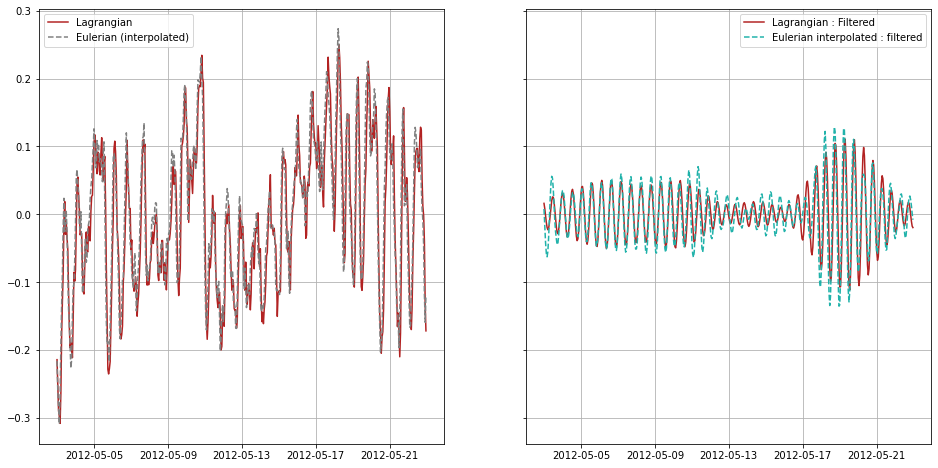

In [126]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time,np.real(_df2.zonal_velocity),c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp2_u,c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df2.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(interp2_hatr),c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
#ax[0].set_title('Real part')

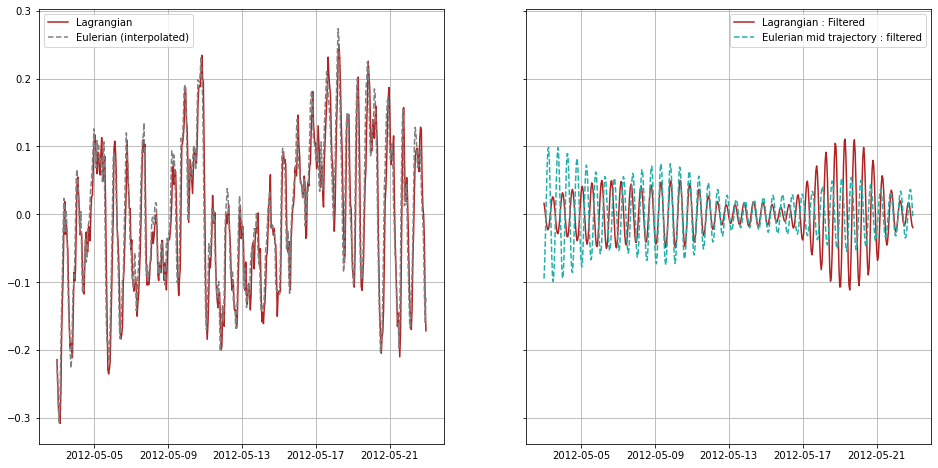

In [127]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time,np.real(_df2.zonal_velocity),c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp2_u,c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df2.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(interp_mid2_hatr),c='lightseagreen',linestyle='--',label='Eulerian mid trajectory : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
#ax[0].set_title('Real part')

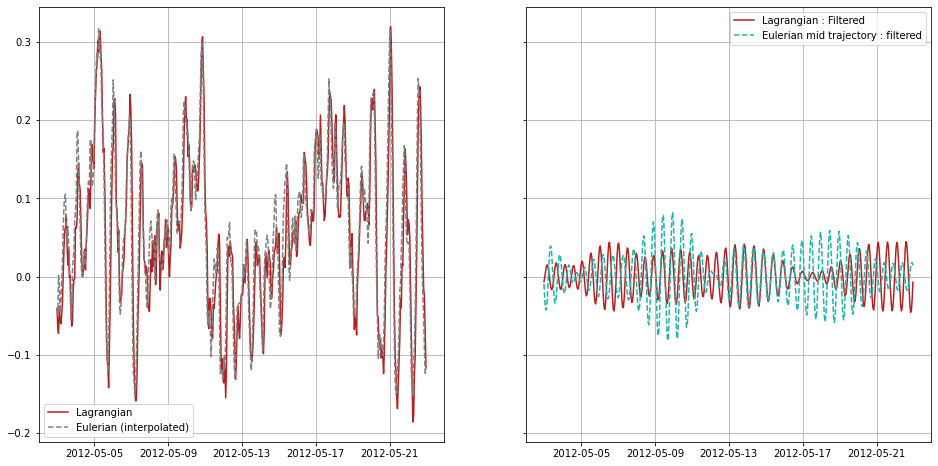

In [160]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,np.real(_df1.zonal_velocity),c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp_u,c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df1.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(interp_mid_hatr),c='lightseagreen',linestyle='--',label='Eulerian mid trajectory : filtered')
ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()

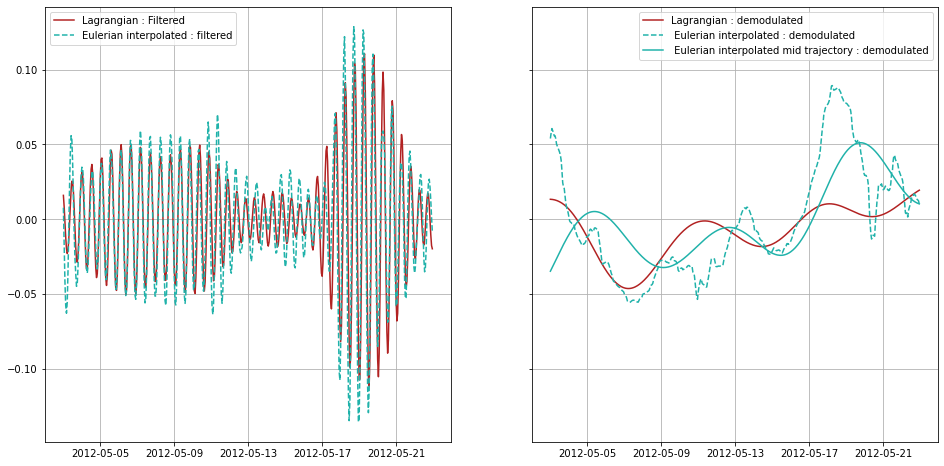

In [128]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time,np.real(_df2.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df2.zonal_velocity_demodulated),c='firebrick',linestyle='-',label='Lagrangian : demodulated')
#plt.plot(time,np.real(df2_demod_bis[t_mid-dtime:t_mid+dtime]),c='firebrick',linestyle='--',label='Lagrangian (one trajectory) : demodulated')

ax[0].plot(time,np.real(interp2_hatr),c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,np.real(interp2_demodr),c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,np.real(interp_mid2_demodr),c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

#ax[1].plot(time,interp_demodr,c='grey',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
#ax[0].set_title('Real part')

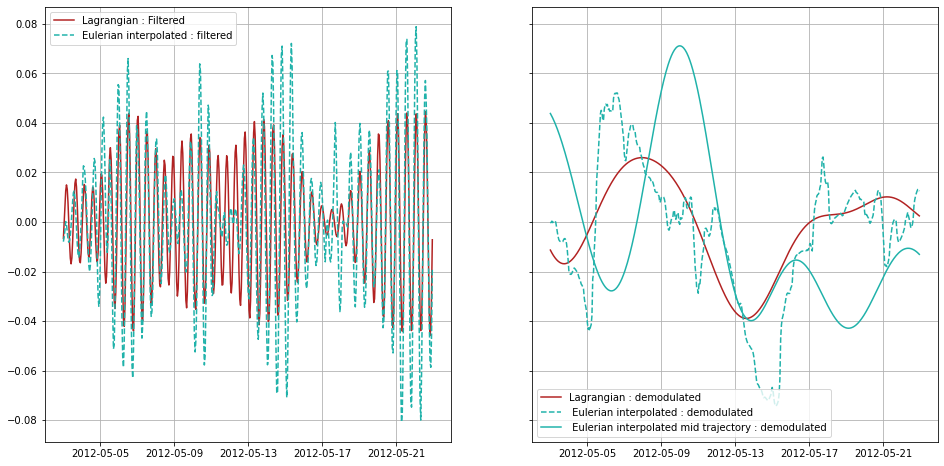

In [159]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,np.real(_df1.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df1.zonal_velocity_demodulated),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,np.real(interp_hatr),c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,np.real(interp_demodr),c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,np.real(interp_mid_demodr),c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()

ax[1].legend();ax[1].grid()

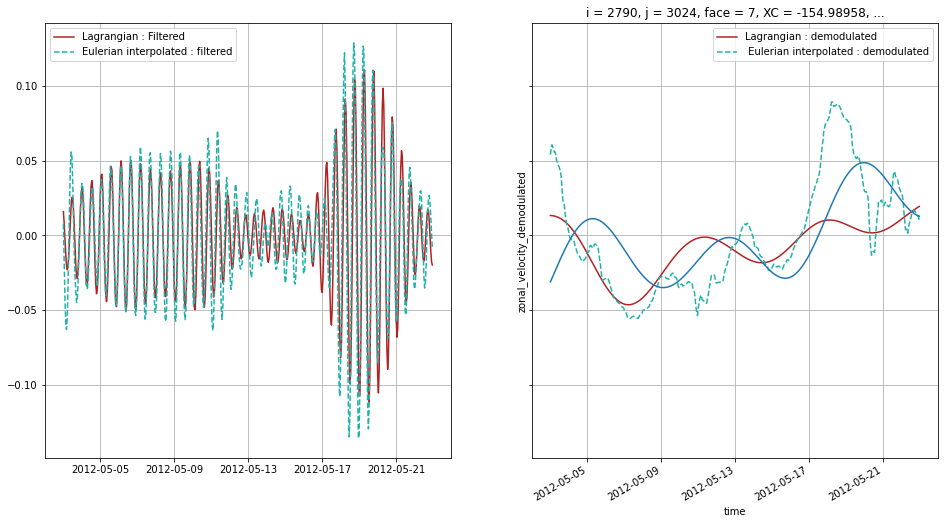

In [130]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time,np.real(_df2.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df2.zonal_velocity_demodulated),c='firebrick',linestyle='-',label='Lagrangian : demodulated')
#plt.plot(time,np.real(df2_demod_bis[t_mid-dtime:t_mid+dtime]),c='firebrick',linestyle='--',label='Lagrangian (one trajectory) : demodulated')

ax[0].plot(time,np.real(interp2_hatr),c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,np.real(interp2_demodr),c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ds_mid_2.zonal_velocity_demodulated.real.plot(ax=ax[1])
#ax[1].plot(time,np.real(interp_mid2_demodr),c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

#ax[1].plot(time,interp_demodr,c='grey',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
#ax[0].set_title('Real part')

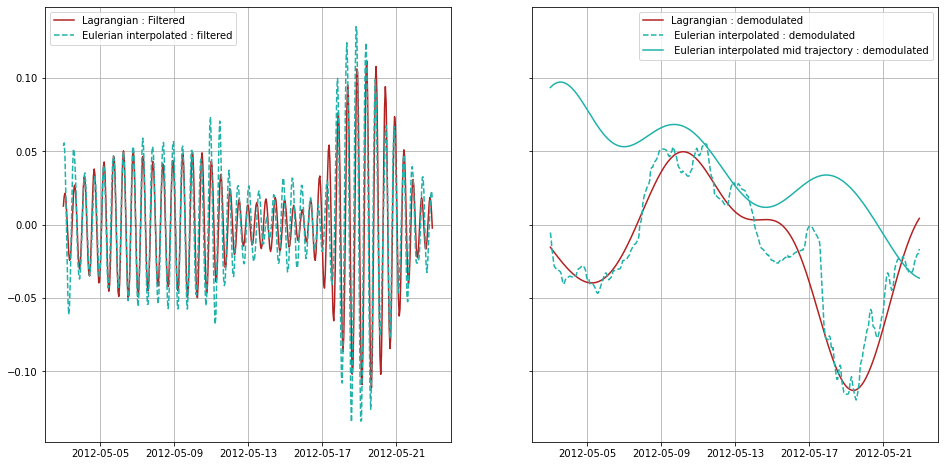

In [131]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time,np.imag(_df2.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df2.zonal_velocity_demodulated),c='firebrick',linestyle='-',label='Lagrangian : demodulated')
#plt.plot(time,np.real(df2_demod_bis[t_mid-dtime:t_mid+dtime]),c='firebrick',linestyle='--',label='Lagrangian (one trajectory) : demodulated')

ax[0].plot(time,interp2_hati,c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2_demodi,c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
#ds_mid_2.zonal_velocity_demodulated.real.plot(ax=ax[1])
ax[1].plot(time,interp_mid2_demodi,c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

#ax[1].plot(time,interp_demodr,c='grey',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
#ax[0].set_title('Real part')



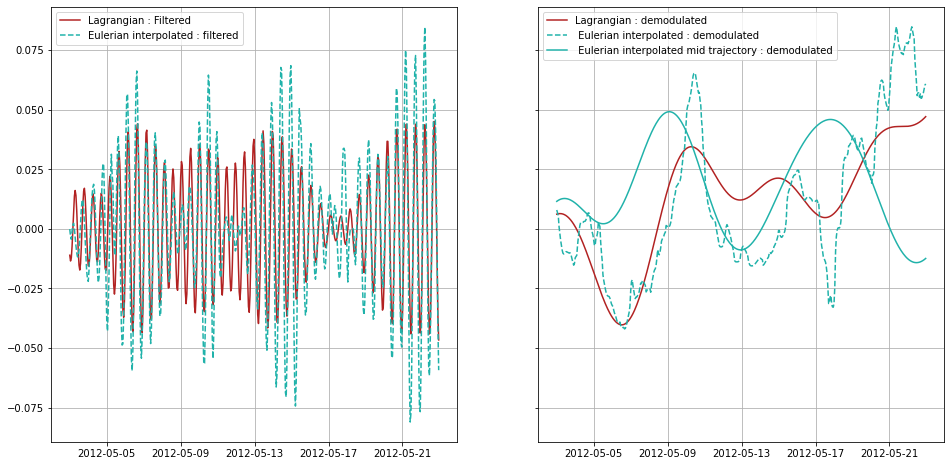

In [158]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time,np.imag(_df1.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df1.zonal_velocity_demodulated),c='firebrick',linestyle='-',label='Lagrangian : demodulated')
#plt.plot(time,np.real(df2_demod_bis[t_mid-dtime:t_mid+dtime]),c='firebrick',linestyle='--',label='Lagrangian (one trajectory) : demodulated')

ax[0].plot(time,interp_hati,c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp_demodi,c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
#ds_mid_2.zonal_velocity_demodulated.real.plot(ax=ax[1])
ax[1].plot(time,interp_mid_demodi,c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

#ax[1].plot(time,interp_demodr,c='grey',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()

### Low pass : 

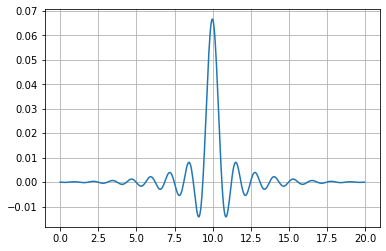

In [132]:
dt = 1. # in hours
T = 20
omega = 1/30
h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)

ax = plt.subplot(111)
ax.plot(np.arange(0,T,dt/24),h)
ax.grid()


In [133]:
V = ['zonal_velocity']
ds_hat_low = xr.merge([filt(dsp[v], h,hilbert=False).rename(v+'_hat') for v in V]).persist()

In [134]:
#df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
#                                                      ).drop(columns='trajectory').reset_index().set_index('time').persist()
df_filtered_low = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=False).persist()
#df_filtered = df_filtered.repartition(npartitions=10).persist()

df_filtered_low = df_filtered_low.drop(columns='trajectory').reset_index().sort_values('time').set_index('time').persist()

<ipython-input-134-10f1764046b3>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered_low = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=False).persist()


In [135]:
dsi_low = ds_hat_low.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
_df1_low = df_filtered_low.loc[dsi_low.time.values][df_filtered_low.loc[dsi_low.time.values].trajectory==37000174].compute()
_df2_low = df_filtered_low.loc[dsi_low.time.values][df_filtered_low.loc[dsi_low.time.values].trajectory==38000248].compute()
_df3_low = df_filtered_low.loc[dsi_low.time.values][df_filtered_low.loc[dsi_low.time.values].trajectory==38001401].compute()
_df4_low = df_filtered_low.loc[dsi_low.time.values][df_filtered_low.loc[dsi_low.time.values].trajectory==38000024].compute()
_df5_low = df_filtered_low.loc[dsi_low.time.values][df_filtered_low.loc[dsi_low.time.values].trajectory==38000172].compute()
_df6_low = df_filtered_low.loc[dsi_low.time.values][df_filtered_low.loc[dsi_low.time.values].trajectory==38000097].compute()

In [136]:
v = 'zonal_velocity_hat'
interp_hat_low,interp_mid_hat_low = interp_sig(_df1_low,dsi_low,v,_df1_low.index.values,part='real')
interp2_hat_low,interp_mid2_hat_low = interp_sig(_df2_low,dsi_low,v,_df2_low.index.values,part='real')

In [143]:
dsi['low_sd'] = dsi_low.zonal_velocity_hat+dsi.zonal_velocity_hat.real

In [144]:
v = 'low_sd'
interp_hat_low_sd,interp_mid_hat_low_sd = interp_sig(_df1,dsi,v,_df1.index.values,part='real')
interp2_hatr_low_sd,interp_mid2_hat_low_sd = interp_sig(_df2,dsi,v,_df2.index.values,part='real')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


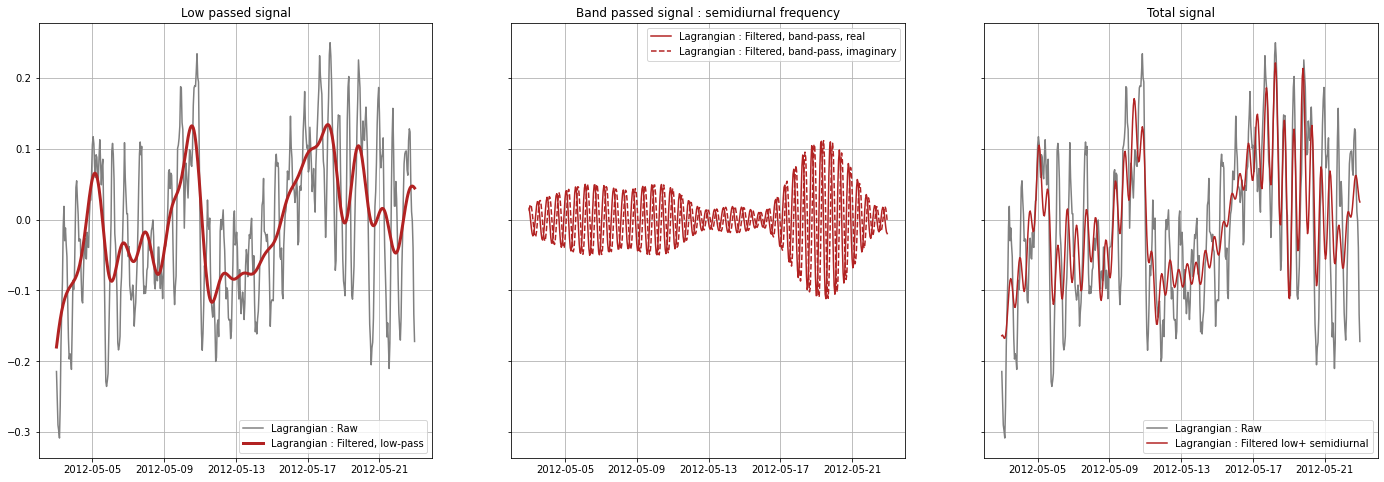

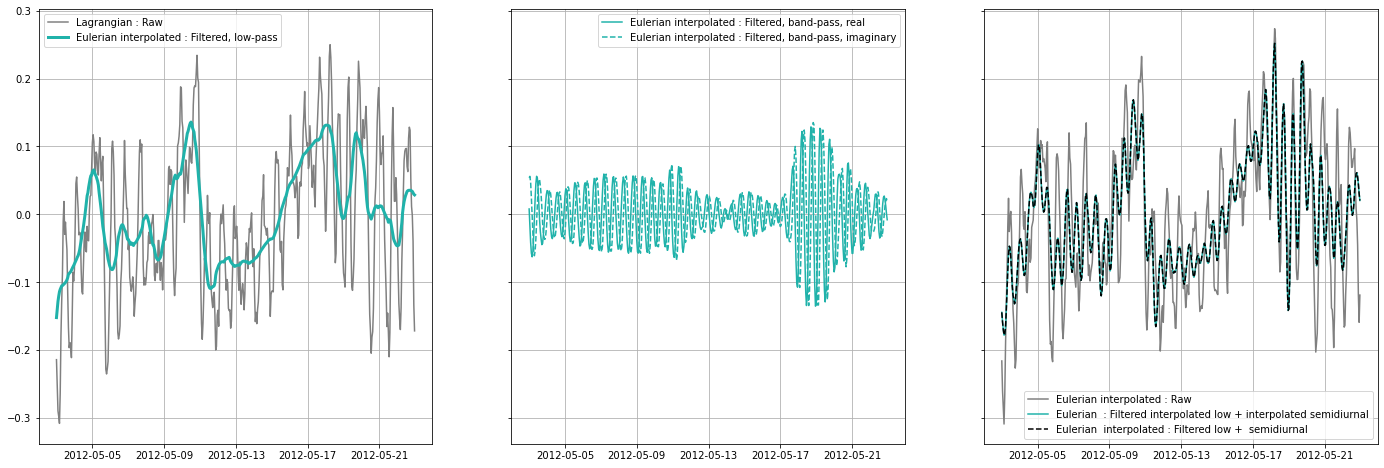

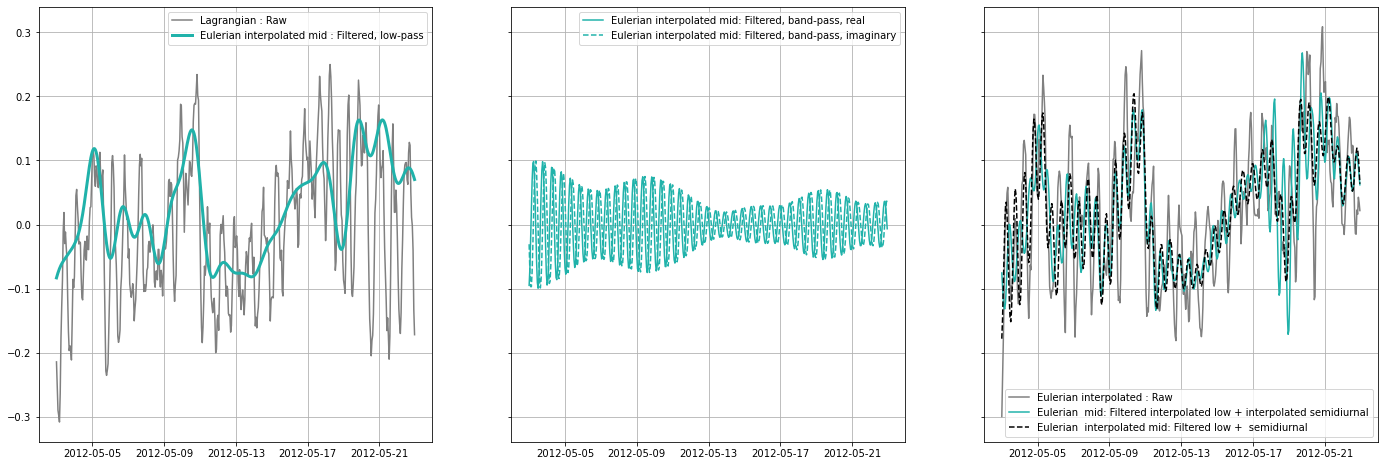

In [155]:
fig,ax = plt.subplots(1,3,figsize=(24,8),sharey=True)
ax[0].plot(time,_df2.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[0].plot(time,_df2_low.zonal_velocity_hat,c='firebrick',linestyle='-',label='Lagrangian : Filtered, low-pass',linewidth=3)


ax[1].plot(time,np.real(_df2.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered, band-pass, real')
ax[1].plot(time,np.imag(_df2.zonal_velocity_hat),c='firebrick',linestyle='--',label='Lagrangian : Filtered, band-pass, imaginary')
ax[2].plot(time,_df2.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[2].plot(time,_df2.zonal_velocity_hat+np.real(_df2_low.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered low+ semidiurnal')
ax[0].legend();ax[0].grid();ax[2].grid()
ax[1].legend();ax[1].grid();ax[2].legend()
ax[0].set_title('Low passed signal');ax[1].set_title('Band passed signal : semidiurnal frequency')
ax[2].set_title('Total signal')
fig,ax = plt.subplots(1,3,figsize=(24,8),sharey=True)
ax[0].plot(time,_df2.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[0].plot(time,interp2_hat_low,c='lightseagreen',linestyle='-',label='Eulerian interpolated : Filtered, low-pass',linewidth=3)


ax[1].plot(time,interp2_hatr,c='lightseagreen',linestyle='-',label='Eulerian interpolated : Filtered, band-pass, real')
ax[1].plot(time,interp2_hati,c='lightseagreen',linestyle='--',label='Eulerian interpolated : Filtered, band-pass, imaginary')
ax[2].plot(time,interp2_u,c='grey',linestyle='-',label='Eulerian interpolated : Raw')
ax[2].plot(time,interp2_hat_low+interp2_hatr,c='lightseagreen',linestyle='-',label='Eulerian  : Filtered interpolated low + interpolated semidiurnal')
ax[2].plot(time,interp2_hatr_low_sd,c='k',linestyle='--',label='Eulerian  interpolated : Filtered low +  semidiurnal')

ax[0].legend();ax[0].grid();ax[2].grid()
ax[1].legend();ax[1].grid();ax[2].legend()

fig,ax = plt.subplots(1,3,figsize=(24,8),sharey=True)
ax[0].plot(time,_df2.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[0].plot(time,interp_mid2_hat_low,c='lightseagreen',linestyle='-',label='Eulerian interpolated mid : Filtered, low-pass',linewidth=3)


ax[1].plot(time,interp_mid2_hatr,c='lightseagreen',linestyle='-',label='Eulerian interpolated mid: Filtered, band-pass, real')
ax[1].plot(time,interp_mid2_hati,c='lightseagreen',linestyle='--',label='Eulerian interpolated mid: Filtered, band-pass, imaginary')
ax[2].plot(time,interp_u_mid2,c='grey',linestyle='-',label='Eulerian interpolated : Raw')
ax[2].plot(time,interp_mid2_hat_low+interp2_hatr,c='lightseagreen',linestyle='-',label='Eulerian  mid: Filtered interpolated low + interpolated semidiurnal')
ax[2].plot(time,interp_mid2_hat_low_sd,c='k',linestyle='--',label='Eulerian  interpolated mid: Filtered low +  semidiurnal')

ax[0].legend();ax[0].grid();ax[2].grid()
ax[1].legend();ax[1].grid();ax[2].legend()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


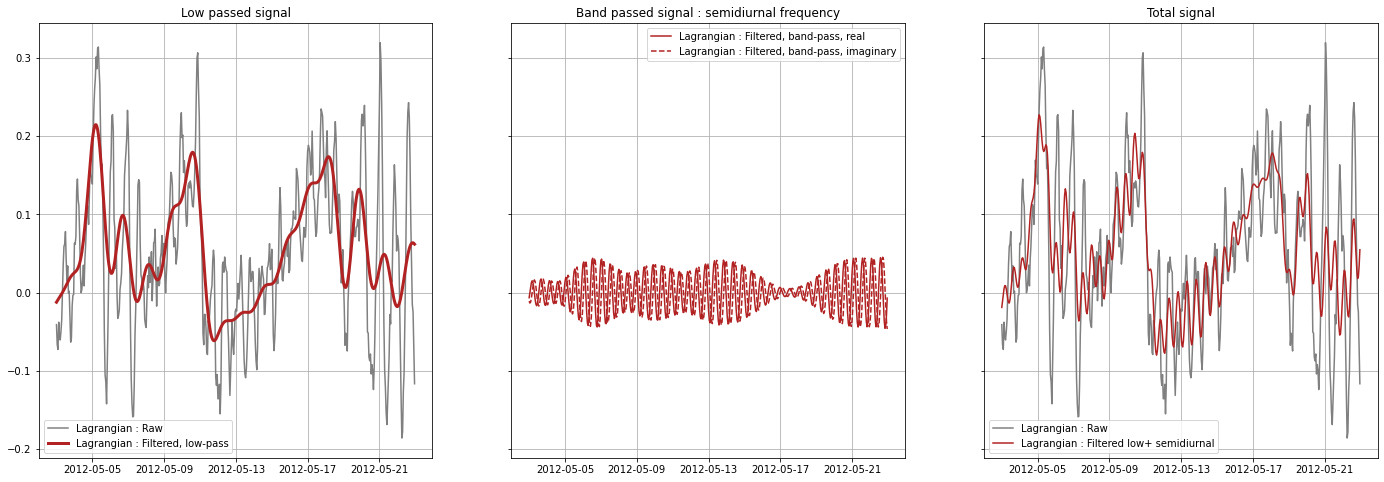

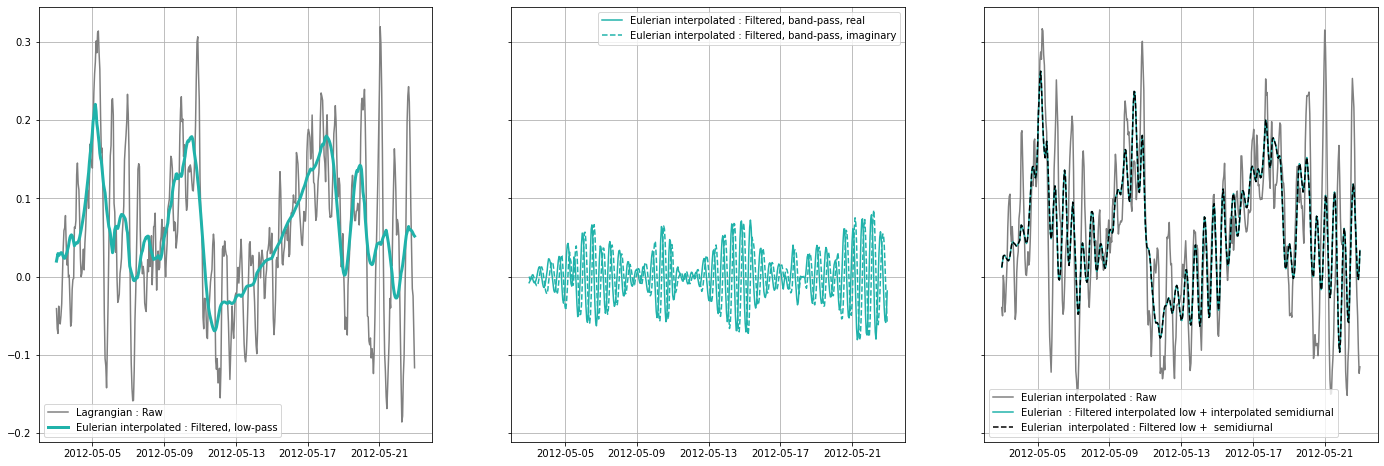

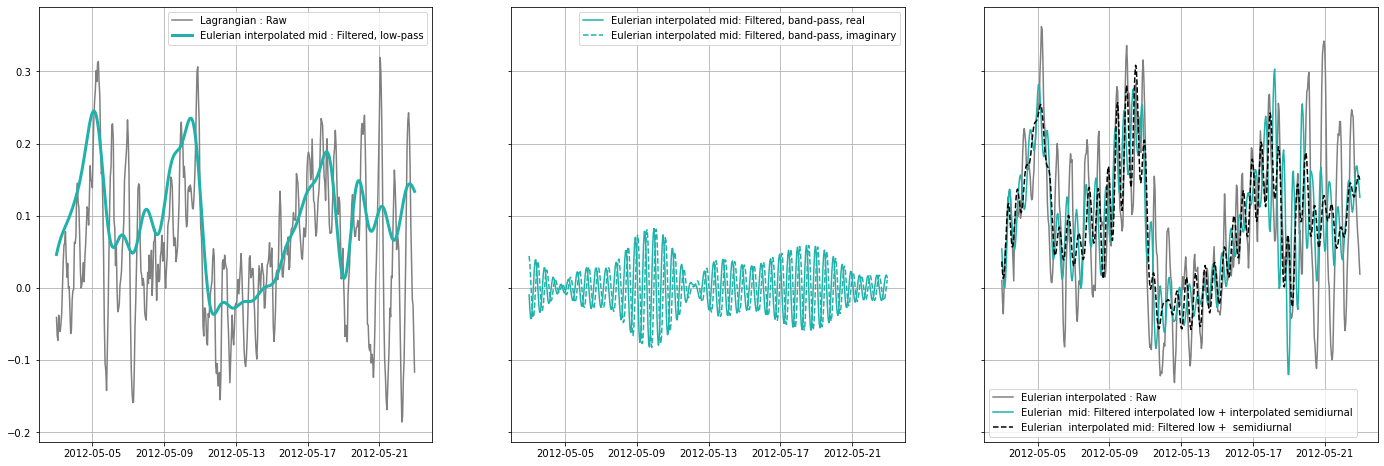

In [157]:
fig,ax = plt.subplots(1,3,figsize=(24,8),sharey=True)
ax[0].plot(time,_df1.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[0].plot(time,_df1_low.zonal_velocity_hat,c='firebrick',linestyle='-',label='Lagrangian : Filtered, low-pass',linewidth=3)


ax[1].plot(time,np.real(_df1.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered, band-pass, real')
ax[1].plot(time,np.imag(_df1.zonal_velocity_hat),c='firebrick',linestyle='--',label='Lagrangian : Filtered, band-pass, imaginary')
ax[2].plot(time,_df1.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[2].plot(time,_df1.zonal_velocity_hat+np.real(_df1_low.zonal_velocity_hat),c='firebrick',linestyle='-',label='Lagrangian : Filtered low+ semidiurnal')
ax[0].legend();ax[0].grid();ax[2].grid()
ax[1].legend();ax[1].grid();ax[2].legend()
ax[0].set_title('Low passed signal');ax[1].set_title('Band passed signal : semidiurnal frequency')
ax[2].set_title('Total signal')
fig,ax = plt.subplots(1,3,figsize=(24,8),sharey=True)
ax[0].plot(time,_df1.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[0].plot(time,interp_hat_low,c='lightseagreen',linestyle='-',label='Eulerian interpolated : Filtered, low-pass',linewidth=3)


ax[1].plot(time,interp_hatr,c='lightseagreen',linestyle='-',label='Eulerian interpolated : Filtered, band-pass, real')
ax[1].plot(time,interp_hati,c='lightseagreen',linestyle='--',label='Eulerian interpolated : Filtered, band-pass, imaginary')
ax[2].plot(time,interp_u,c='grey',linestyle='-',label='Eulerian interpolated : Raw')
ax[2].plot(time,interp_hat_low+interp_hatr,c='lightseagreen',linestyle='-',label='Eulerian  : Filtered interpolated low + interpolated semidiurnal')
ax[2].plot(time,interp_hat_low_sd,c='k',linestyle='--',label='Eulerian  interpolated : Filtered low +  semidiurnal')

ax[0].legend();ax[0].grid();ax[2].grid()
ax[1].legend();ax[1].grid();ax[2].legend()

fig,ax = plt.subplots(1,3,figsize=(24,8),sharey=True)
ax[0].plot(time,_df1.zonal_velocity,c='grey',linestyle='-',label='Lagrangian : Raw')
ax[0].plot(time,interp_mid_hat_low,c='lightseagreen',linestyle='-',label='Eulerian interpolated mid : Filtered, low-pass',linewidth=3)


ax[1].plot(time,interp_mid_hatr,c='lightseagreen',linestyle='-',label='Eulerian interpolated mid: Filtered, band-pass, real')
ax[1].plot(time,interp_mid_hati,c='lightseagreen',linestyle='--',label='Eulerian interpolated mid: Filtered, band-pass, imaginary')
ax[2].plot(time,interp_u_mid,c='grey',linestyle='-',label='Eulerian interpolated : Raw')
ax[2].plot(time,interp_mid_hat_low+interp2_hatr,c='lightseagreen',linestyle='-',label='Eulerian  mid: Filtered interpolated low + interpolated semidiurnal')
ax[2].plot(time,interp_mid_hat_low_sd,c='k',linestyle='--',label='Eulerian  interpolated mid: Filtered low +  semidiurnal')

ax[0].legend();ax[0].grid();ax[2].grid()
ax[1].legend();ax[1].grid();ax[2].legend()

Text(0.5, 1.0, 'Interpolated Eulerian : imaginary part')

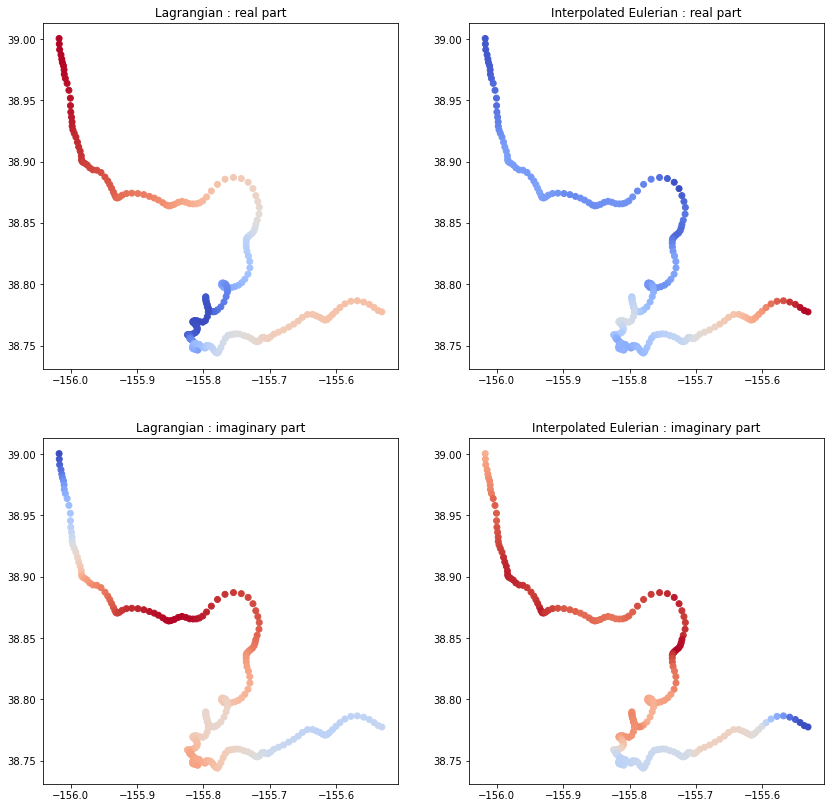

In [93]:
fig,ax = plt.subplots(2,2,figsize=(14,14))
ax[0,0].scatter(_df1.lon,_df1.lat,c=np.real(_df1.zonal_velocity_demodulated),cmap='coolwarm');
ax[0,1].scatter(_df1.lon,_df1.lat,c=interp_demodr,cmap='coolwarm');
ax[0,0].set_title('Lagrangian : real part');ax[0,1].set_title('Interpolated Eulerian : real part')
#ax[0].scatter(dfi_2.lon,dfi_2.lat,s=1,c=np.real(dfi_2.zonal_velocity_demodulated))
ax[1,0].scatter(_df1.lon,_df1.lat,c=np.imag(_df1.zonal_velocity_demodulated),cmap='coolwarm');
ax[1,1].scatter(_df1.lon,_df1.lat,c=interp_demodi,cmap='coolwarm');
ax[1,0].set_title('Lagrangian : imaginary part');ax[1,1].set_title('Interpolated Eulerian : imaginary part')


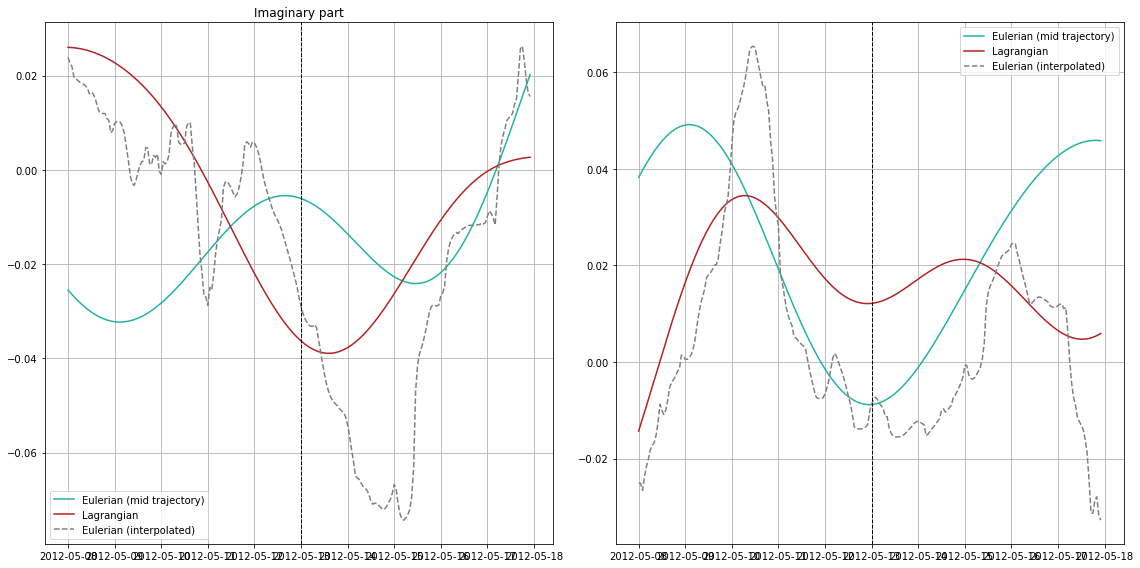

In [94]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],np.real(_df1.zonal_velocity_demodulated)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp2_demodr[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[0].legend();ax[0].grid()
ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Real part')
ax[1].plot(time[:-1],interp_mid2_demodi[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[1].plot(time[:-1],np.imag(_df1.zonal_velocity_demodulated)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[1].plot(time[:-1],interp2_demodi[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].legend();ax[1].grid()
ax[1].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Imaginary part')
fig.tight_layout()

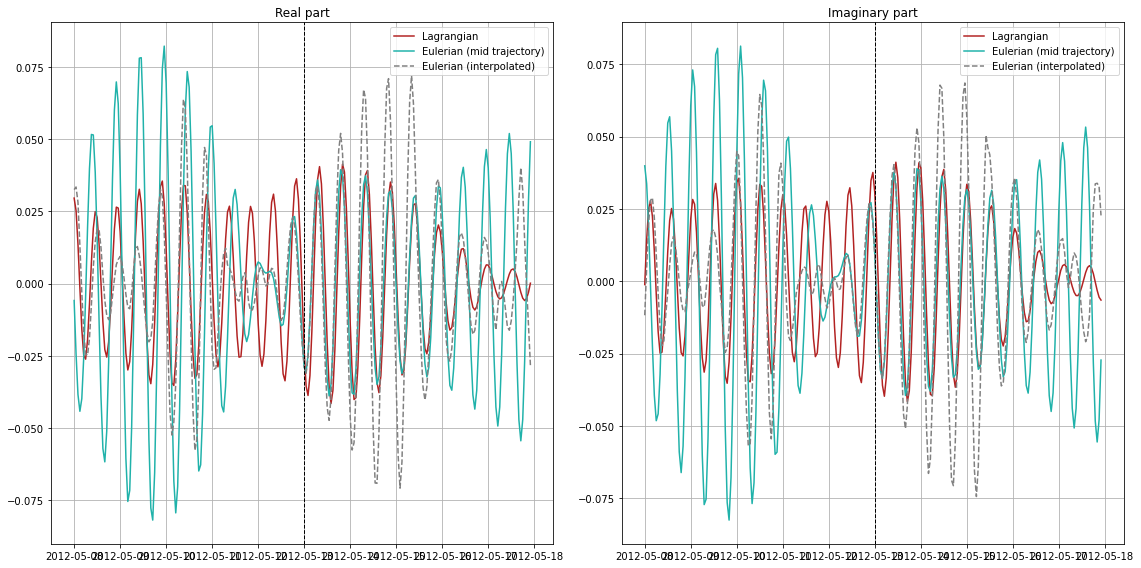

In [95]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(time[:-1],np.real(_df1.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp_mid2_hatr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],interp2_hatr[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[0].legend();ax[0].grid()
ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Real part')

ax[1].plot(time[:-1],np.imag(_df1.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[1].plot(time[:-1],interp_mid2_hati[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[1].plot(time[:-1],interp2_hati[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].legend();ax[1].grid()
ax[1].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].set_title('Imaginary part')
fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-84-c499af89b652>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


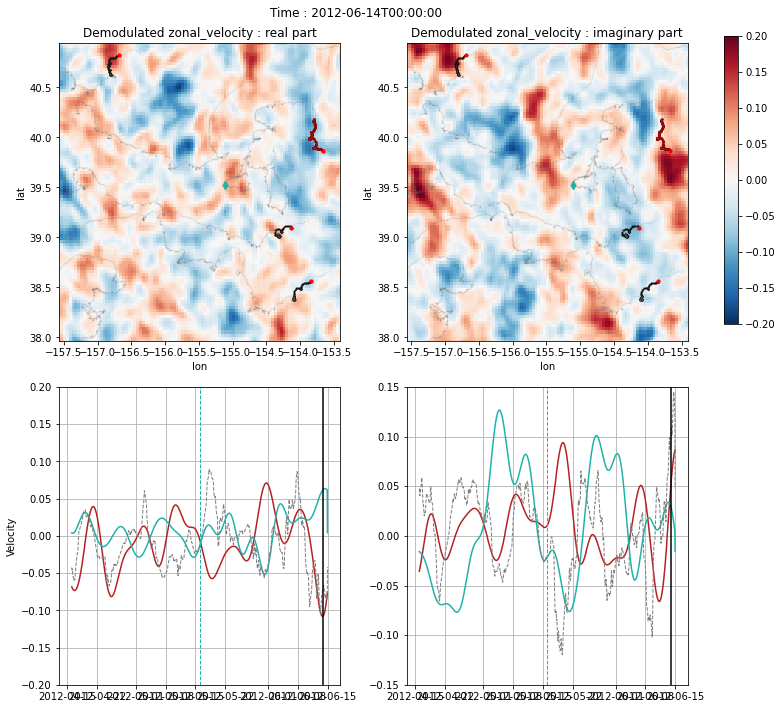

In [85]:
_df = [_df1,_df2,_df3,_df4,_df5,_df6]
gen_figs_flts_interp(_df,[interp_demodr,interp_demodi,interp_mid_demodr,interp_mid_demodi],30*24,'zonal_velocity',1/24,savefig=False
             )

In [86]:
IT = np.arange(0,dsi.time.size)
for it in IT:
    gen_figs_flts_interp(_df,[interp_demodr,interp_demodi,interp_mid_demodr,interp_mid_demodi],
                         it,'zonal_velocity',1/24,savefig=True
                        )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-84-c499af89b652>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarn

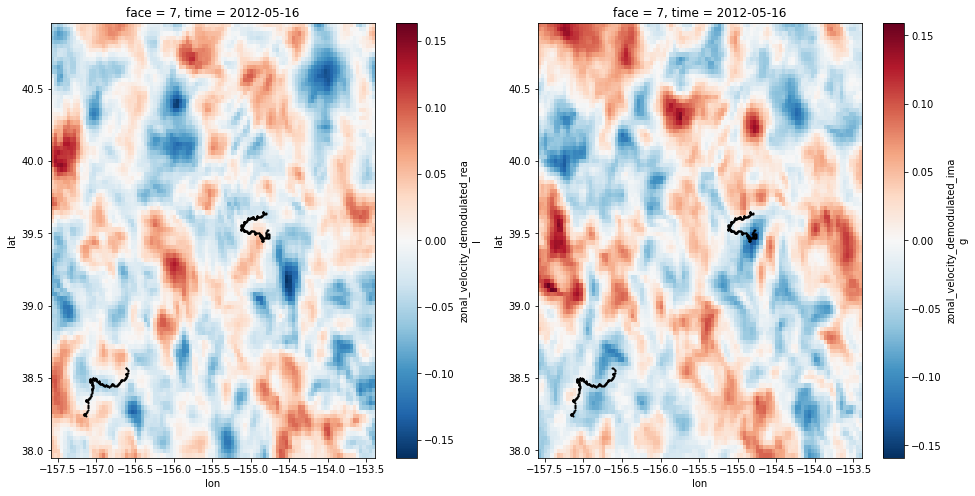

In [90]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
dsi.isel(time=time.size//2).zonal_velocity_demodulated_real.plot(ax=ax[0],x='lon',y='lat')
ax[0].scatter(dfi.lon,dfi.lat,s=1,c='k');ax[0].scatter(dfi_2.lon,dfi_2.lat,s=1,c='k')
dsi.isel(time=time.size//2).zonal_velocity_demodulated_imag.plot(ax=ax[1],x='lon',y='lat')
ax[1].scatter(dfi.lon,dfi.lat,s=1,c='k');ax[1].scatter(dfi_2.lon,dfi_2.lat,s=1,c='k')

In [8]:
cluster.close()